In [574]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [575]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [576]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 4800
Test set size: 1200


In [577]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])

In [578]:
num_features = 3
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

In [579]:
from model_poses import get_model_pose_prediction_and_error
pred_poses,dim1_data,dim2_data,dim3_data,pred_poses_x,pred_poses_y,pred_poses_theta \
= get_model_pose_prediction_and_error(train_RO_se3s)

4800
4799
4798


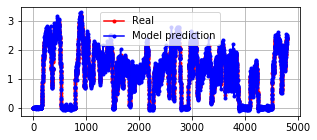

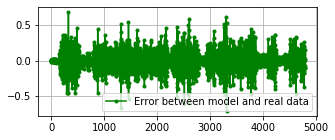

In [580]:
print(len(train_RO_se3s))
print(len(pred_poses))
print(len(dim1_data))    

plt.figure(figsize=(5,2))
plt.plot(t_x_data[2:],'r.-',label='Real') # cropping first 2 frames here to align plots
plt.plot(pred_poses_x,'b.-',label='Model prediction')
plt.legend()
plt.grid()

plt.figure(figsize=(5,2))
plt.plot(dim1_data,'g.-',label='Error between model and real data')
plt.legend()
plt.grid()

In [581]:
use_toy_data = False
if(use_toy_data):
    from toy_data import make_toy_data
    data_size = 100
    toy_x_model_err,toy_x_data,toy_x_pred = make_toy_data(10,data_size)
    toy_y_model_err,toy_y_data,toy_y_pred = make_toy_data(1,data_size)
    toy_theta_model_err,toy_theta_data,toy_theta_pred = make_toy_data(0.1,data_size)
        
    # hack to allow the rest of the code to remain the same
    t_x_data = toy_x_data
    dim1_data = np.array(toy_x_model_err)
    pred_poses_x = np.array(toy_x_pred)
    t_y_data = toy_y_data
    dim2_data = np.array(toy_y_model_err)
    pred_poses_y = np.array(toy_y_pred)
    t_theta_data = toy_theta_data
    dim3_data = np.array(toy_theta_model_err)
    pred_poses_theta = np.array(toy_theta_pred)

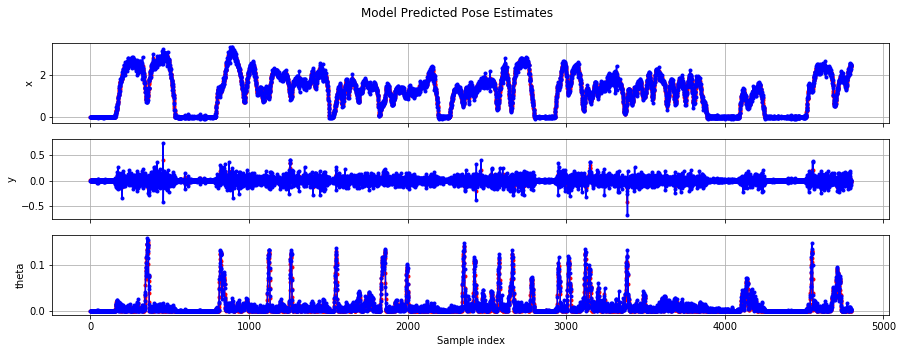

In [582]:
# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Model Predicted Pose Estimates')
axs[0].plot(t_x_data[2:],'r.-')
axs[0].plot(pred_poses_x,'b.-')
axs[0].set(ylabel = 'x')
axs[1].plot(t_y_data[2:],'r.-')
axs[1].plot(pred_poses_y,'b.-')
axs[1].set(ylabel = 'y')
axs[2].plot(t_theta_data[2:],'r.-')
axs[2].plot(pred_poses_theta,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

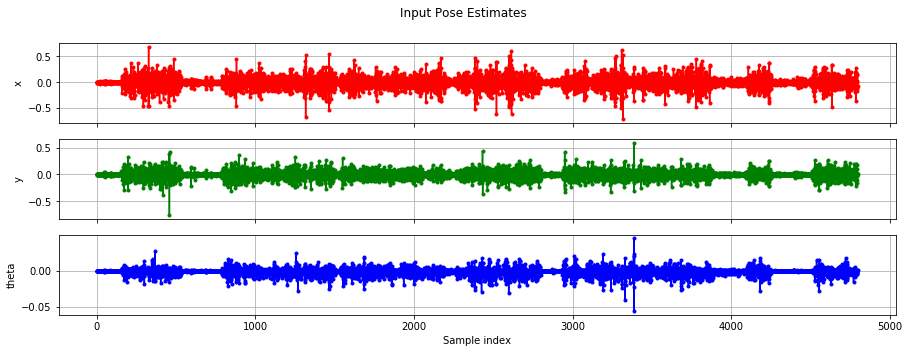

In [583]:
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
dim3_data_scaled = (dim3_data - dim3_data.mean())/dim3_data.std()

# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')
axs[1].plot(dim2_data,'g.-')
axs[1].set(ylabel = 'y')
axs[2].plot(dim3_data,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [584]:
from dataset_prep import prepare_data
train_validate_ratio = 0.9
train_ds,valid_ds = \
prepare_data(dim1_data_scaled,dim2_data_scaled,dim3_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([4796, 6])
x_train dimensions: torch.Size([4316, 6])
x_valid dimensions: torch.Size([480, 6])
y_data dimensions: torch.Size([4796, 3])
y_train dimensions: torch.Size([4316, 3])
y_valid dimensions: torch.Size([480, 3])


In [585]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

epochs = 30
lr = 1e-2
batch_size = 30

model = Pose_Logistic()
loss_func = nn.MSELoss()

from network_helpers import *

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = Pose_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.5547063341364264
1 0.49222770892083645
2 0.4674816820770502
3 0.45553010515868664
4 0.44969660695642233
5 0.4466169704683125
6 0.4444493274204433
7 0.4436201537027955
8 0.4426881452091038
9 0.4420404611155391
10 0.4427248784340918
11 0.4424256831407547
12 0.44206443382427096
13 0.4412818606942892
14 0.44087048759683967
15 0.44179203687235713
16 0.44242465822026134
17 0.44188421219587326
18 0.441738011315465
19 0.442374914418906
20 0.4425974045880139
21 0.4426141167059541
22 0.44270817982032895
23 0.4423354514874518
24 0.44293594965711236
25 0.44169751554727554
26 0.44177525117993355
27 0.4424701421521604
28 0.4434883897192776
29 0.4425643589347601


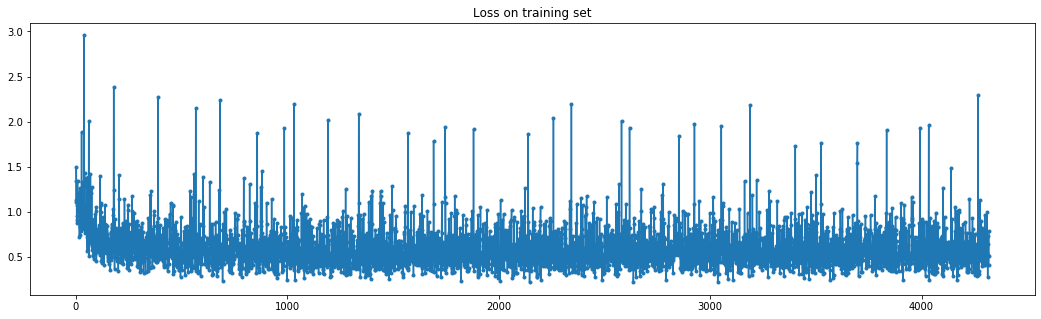

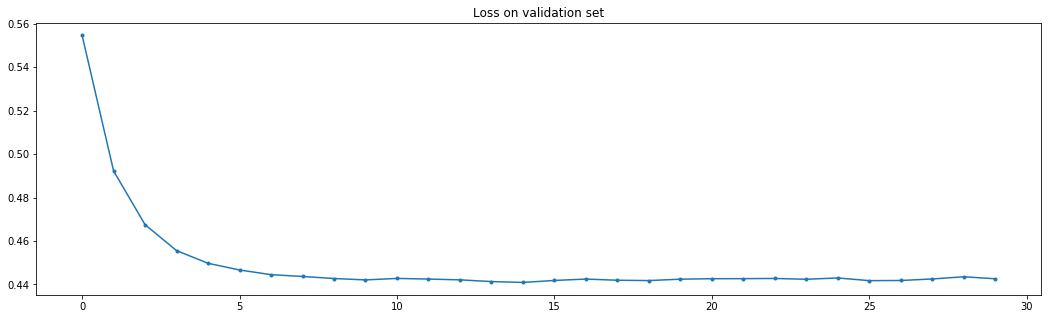

In [586]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

In [587]:
from inference import query_at_index
idx = 50
predicted_error_x,predicted_error_y,predicted_error_theta = \
query_at_index(model,dim1_data,dim2_data,dim3_data,num_frames,num_features,idx)

print(predicted_error_x)
print(predicted_error_y)
print(predicted_error_theta)
print('True answer:',dim1_data[idx+num_frames],dim2_data[idx+num_frames],dim3_data[idx+num_frames])
print('...at frame',idx+num_frames)

tensor(0.0099)
tensor(-0.0086)
tensor(-0.0017)
True answer: 0.02317683906121009 0.0006483819688655923 -0.0001917301754812469
...at frame 52


Model pose RMSE error: 0.11688580103573619
Predicted pose RMSE error: 0.04674479729682335


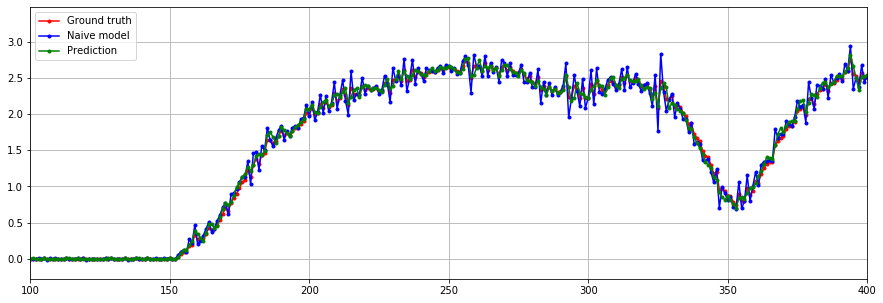

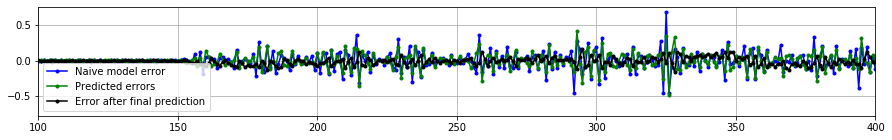

In [588]:
predicted_errors_x = np.zeros(len(dim1_data)-num_frames+1)
final_predictions_x = np.zeros(len(predicted_errors_x))
final_err_x = np.zeros(len(final_predictions_x))

predicted_errors_y = np.zeros(len(dim2_data)-num_frames+1)
final_predictions_y = np.zeros(len(predicted_errors_y))
final_err_y = np.zeros(len(final_predictions_y))

predicted_errors_theta = np.zeros(len(dim3_data)-num_frames+1)
final_predictions_theta = np.zeros(len(predicted_errors_theta))
final_err_theta = np.zeros(len(final_predictions_theta))

for i in range(len(predicted_errors_x)): 
    predicted_errors_x[i],predicted_errors_y[i],predicted_errors_theta[i] = \
    query_at_index(model,dim1_data,dim2_data,dim3_data,num_frames,num_features,i)

    final_predictions_x[i] = pred_poses_x[i+num_frames] + predicted_errors_x[i]
    final_predictions_y[i] = pred_poses_y[i+num_frames] + predicted_errors_y[i]
    final_predictions_theta[i] = pred_poses_theta[i+num_frames] + predicted_errors_theta[i]

# Need 3 observations to generate an error (and a subsequent 1-frame prediction)
# 2 frames: 4 observations -> 1 error prediction
# 3 frames: 5 observations -> 1 error prediction
# Therefore the offset is always 1 more than the number of frames used to make up an input
pred_offset = num_frames + 1

# the -1 is because we predict +1 in the future, and so the last prediction has
# no frame from the real data to be compared against
for i in range(len(predicted_errors_x)-1): 
    final_err_x[i] = t_x_data[i+pred_offset] - final_predictions_x[i]
    final_err_y[i] = t_y_data[i+pred_offset] - final_predictions_y[i]
    final_err_theta[i] = t_theta_data[i+pred_offset] - final_predictions_theta[i]

plot_idx_start = 100
plot_idx_end = 400
    
plt.figure(figsize=(15,5))
plt.plot(t_x_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_x[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_x,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

plt.figure(figsize=(15,2))
plt.plot(dim1_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_x,'g.-',label='Predicted errors')
plt.plot(final_err_x,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

print("Model pose RMSE error:",np.sqrt(np.sum(np.square(dim1_data))/len(dim1_data)))
print("Predicted pose RMSE error:",np.sqrt(np.sum(np.square(final_err_x))/len(final_err_x)))

(100, 400)

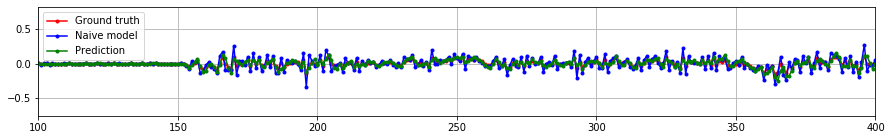

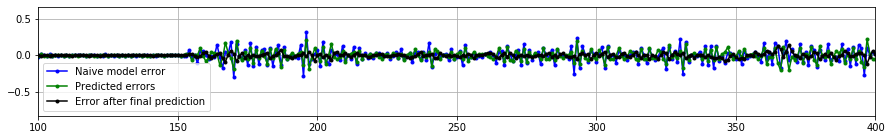

In [589]:
plt.figure(figsize=(15,2))
plt.plot(t_y_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_y[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_y,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

plt.figure(figsize=(15,2))
plt.plot(dim2_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_y,'g.-',label='Predicted errors')
plt.plot(final_err_y,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

(100, 400)

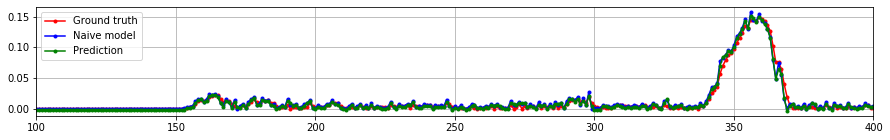

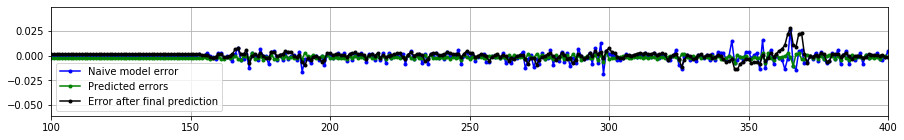

In [590]:
plt.figure(figsize=(15,2))
plt.plot(t_theta_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_theta[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_theta,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

plt.figure(figsize=(15,2))
plt.plot(dim3_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_theta,'g.-',label='Predicted errors')
plt.plot(final_err_theta,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

1200
1199
1198


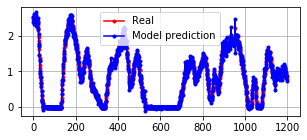

In [591]:
# Test set preparation and results from below this point ***
# Put together quickly, so variable names are not all new (re-used from above, beware)

test_t_x_data = np.zeros(len(test_RO_timestamps))
test_t_y_data = np.zeros(len(test_RO_timestamps))
test_t_theta_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]
    test_t_y_data[i] = test_RO_se3s[i][1,3]
    test_t_theta_data[i] = np.arccos(test_RO_se3s[i][0,0])
    
from model_poses import get_model_pose_prediction_and_error
test_pred_poses,test_dim1_data,test_dim2_data,test_dim3_data,test_pred_poses_x,test_pred_poses_y,test_pred_poses_theta \
= get_model_pose_prediction_and_error(test_RO_se3s)

print(len(test_RO_se3s))
print(len(test_pred_poses))
print(len(test_dim1_data))    

plt.figure(figsize=(5,2))
plt.plot(test_t_x_data[2:],'r.-',label='Real') # cropping first 2 frames here to align plots
plt.plot(test_pred_poses_x,'b.-',label='Model prediction')
plt.legend()
plt.grid()

Model pose RMSE error x: 0.09228199678590973
Predicted pose RMSE error x: 0.04375432795497254


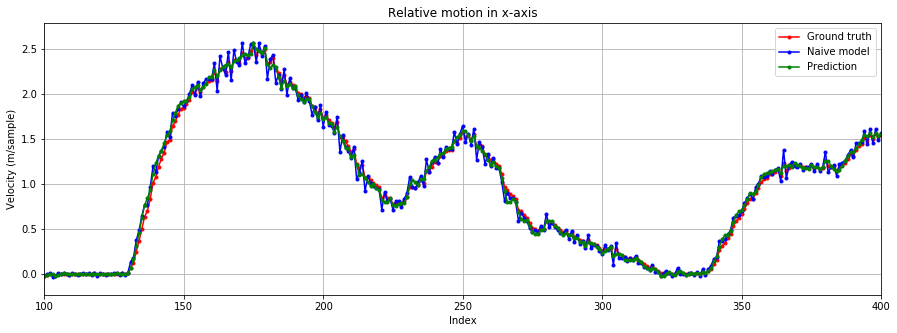

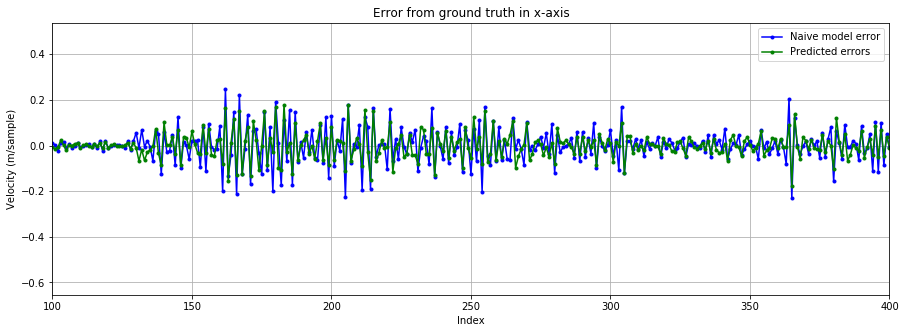

In [592]:
test_predicted_errors_x = np.zeros(len(test_dim1_data)-num_frames+1)
test_final_predictions_x = np.zeros(len(test_predicted_errors_x))
test_final_err_x = np.zeros(len(test_final_predictions_x))

test_predicted_errors_y = np.zeros(len(test_dim2_data)-num_frames+1)
test_final_predictions_y = np.zeros(len(test_predicted_errors_y))
test_final_err_y = np.zeros(len(test_final_predictions_y))

test_predicted_errors_theta = np.zeros(len(test_dim3_data)-num_frames+1)
test_final_predictions_theta = np.zeros(len(test_predicted_errors_theta))
test_final_err_theta = np.zeros(len(test_final_predictions_theta))

for i in range(len(test_predicted_errors_x)): 
    test_predicted_errors_x[i],test_predicted_errors_y[i],test_predicted_errors_theta[i] = \
    query_at_index(model,test_dim1_data,test_dim2_data,test_dim3_data,num_frames,num_features,i)

    test_final_predictions_x[i] = test_pred_poses_x[i+num_frames] + test_predicted_errors_x[i]
    test_final_predictions_y[i] = test_pred_poses_y[i+num_frames] + test_predicted_errors_y[i]
    test_final_predictions_theta[i] = test_pred_poses_theta[i+num_frames] + test_predicted_errors_theta[i]
    
# Need 3 observations to generate an error (and a subsequent 1-frame prediction)
# 2 frames: 4 observations -> 1 error prediction
# 3 frames: 5 observations -> 1 error prediction
# Therefore the offset is always 1 more than the number of frames used to make up an input
pred_offset = num_frames + 1

# the -1 is because we predict +1 in the future, and so the last prediction has
# no frame from the real data to be compared against
for i in range(len(test_predicted_errors_x)-1): 
    test_final_err_x[i] = test_t_x_data[i+pred_offset] - test_final_predictions_x[i]
    test_final_err_y[i] = test_t_y_data[i+pred_offset] - test_final_predictions_y[i]
    test_final_err_theta[i] = test_t_theta_data[i+pred_offset] - test_final_predictions_theta[i]

plt.figure(figsize=(15,5))
plt.plot(test_t_x_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(test_pred_poses_x[num_frames:],'b.-',label='Naive model')
plt.plot(test_final_predictions_x,'g.-',label='Prediction')
plt.title('Relative motion in x-axis')
plt.xlabel('Index')
plt.ylabel('Velocity (m/sample)')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

plt.figure(figsize=(15,5))
plt.plot(test_dim1_data[num_frames:],'b.-',label='Naive model error')
plt.plot(test_predicted_errors_x,'g.-',label='Predicted errors')
# plt.plot(final_err_x,'k.-',label='Error after final prediction')
plt.title('Error from ground truth in x-axis')
plt.xlabel('Index')
plt.ylabel('Velocity (m/sample)')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

print("Model pose RMSE error x:",np.sqrt(np.sum(np.square(test_dim1_data))/len(test_dim1_data)))
print("Predicted pose RMSE error x:",np.sqrt(np.sum(np.square(test_final_err_x))/len(test_final_err_x)))

Model pose RMSE error y: 0.07340730207947446
Predicted pose RMSE error y: 0.02084387195236637


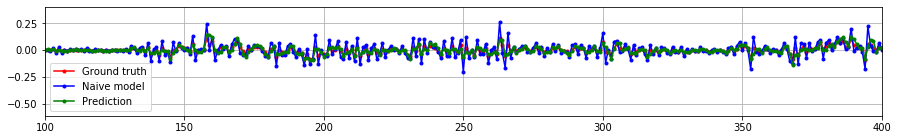

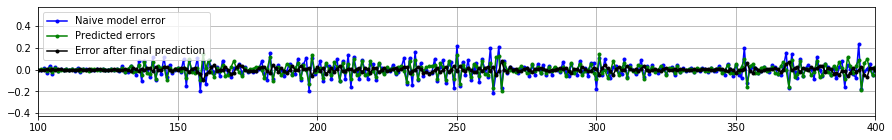

In [593]:
plt.figure(figsize=(15,2))
plt.plot(test_t_y_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(test_pred_poses_y[num_frames:],'b.-',label='Naive model')
plt.plot(test_final_predictions_y,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

plt.figure(figsize=(15,2))
plt.plot(test_dim2_data[num_frames:],'b.-',label='Naive model error')
plt.plot(test_predicted_errors_y,'g.-',label='Predicted errors')
plt.plot(test_final_err_y,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

print("Model pose RMSE error y:",np.sqrt(np.sum(np.square(test_dim2_data))/len(test_dim2_data)))
print("Predicted pose RMSE error y:",np.sqrt(np.sum(np.square(test_final_err_y))/len(test_final_err_y)))

Model pose RMSE error theta: 0.005753514303276233
Predicted pose RMSE error theta: 0.004631799652052054


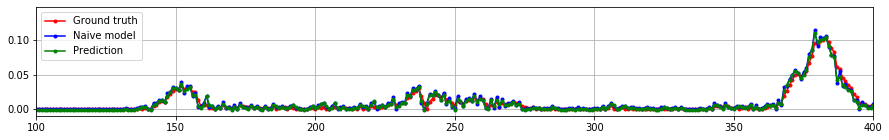

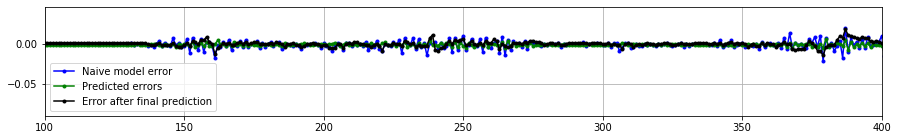

In [598]:
plt.figure(figsize=(15,2))
plt.plot(test_t_theta_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(test_pred_poses_theta[num_frames:],'b.-',label='Naive model')
plt.plot(test_final_predictions_theta,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

plt.figure(figsize=(15,2))
plt.plot(test_dim3_data[num_frames:],'b.-',label='Naive model error')
plt.plot(test_predicted_errors_theta,'g.-',label='Predicted errors')
plt.plot(test_final_err_theta,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)

print("Model pose RMSE error theta:",np.sqrt(np.sum(np.square(test_dim3_data))/len(test_dim3_data)))
print("Predicted pose RMSE error theta:",np.sqrt(np.sum(np.square(test_final_err_theta))/len(test_final_err_theta)))

In [599]:
print("Results")
print("Number of frames used in prediction:",num_frames)
print("Model pose RMSE error x:",np.sqrt(np.sum(np.square(test_dim1_data))/len(test_dim1_data)))
print("Model pose RMSE error y:",np.sqrt(np.sum(np.square(test_dim2_data))/len(test_dim2_data)))
print("Model pose RMSE error theta:",np.sqrt(np.sum(np.square(test_dim3_data))/len(test_dim3_data)))

print("Predicted pose RMSE error x:",np.sqrt(np.sum(np.square(test_final_err_x))/len(test_final_err_x)))
print("Predicted pose RMSE error y:",np.sqrt(np.sum(np.square(test_final_err_y))/len(test_final_err_y)))
print("Predicted pose RMSE error theta:",np.sqrt(np.sum(np.square(test_final_err_theta))/len(test_final_err_theta)))

Results
Number of frames used in prediction: 2
Model pose RMSE error x: 0.09228199678590973
Model pose RMSE error y: 0.07340730207947446
Model pose RMSE error theta: 0.005753514303276233
Predicted pose RMSE error x: 0.04375432795497254
Predicted pose RMSE error y: 0.02084387195236637
Predicted pose RMSE error theta: 0.004631799652052054


In [621]:
abc = -1,-1,-2,-1,-1
print(np.mean(abc))
print(np.std(abc))

-1.2
0.4


In [636]:
abc = -2,-2,-2,-2,-2,1,1,1,1,10
tmp = 0
negative_counter = 0
for i in range(len(abc)):
    if(abc[i]<= 0):
        tmp += abc[i]*abc[i]
        negative_counter += 1
    
print(tmp)
sd = np.sqrt(tmp/negative_counter)
print(sd)

20
2.0
